In [1]:
from utils import make_need_tree,visualize_tree,make_storage,make_task_dict
from tqdm import tqdm
from colors import colors
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
import shutil

In [2]:
storage = make_storage()
storage['fishing net']=20
storage['apple']=20
storage['wool']=20
storage['fish fillet']=100
storage['raspberry']=100

orders = [
            *['carrot pie']*2,
            *['raspberry muffin']*2,
            *['cream cake']*2,
            *['pizza']*7,
            *['fish pie']*2,
            *['bacon and eggs']*3
        ]

In [3]:
task_dict=make_task_dict(orders,storage)
set(task['source'] for task in task_dict.values()),len(task_dict)

({'BBQ Grill',
  'Bakery',
  'Cake Oven',
  'Chicken',
  'Cow',
  'Dairy',
  'Feed Mill',
  'Field',
  'Pie Oven',
  'Pig',
  'Sugar Mill'},
 225)

In [4]:
machines={'Bakery':1, 'Cow':6, 'Feed Mill':1, 'Field':12,'Dairy':1,'Chicken':6,'Sugar Mill':1,
        'Pig':6,'Pie Oven':1,'Cake Oven':1,'BBQ Grill':1}

In [5]:
# generate chromosome
def generate_chromosome(task_dict):
    """
    Generate a chromosome for the genetic algorithm.

    Parameters:
    - task_dict (dict): A dictionary containing task information.

    Returns:
    - chromosome (numpy.ndarray): A 2xlength matrix with integer values.
                                  The first row represents the task IDs,
                                  and the second row represents the machine IDs.
    """
    chromosome = np.zeros((2,len(task_dict))).astype(int)
    tasks = list(task_dict.values())
    random.shuffle(tasks)
    tasks.sort(key=lambda x:x['depth'],reverse=True)
    for i in range(len(tasks)):
        chromosome[0][i]=tasks[i]['id']
        chromosome[1][i]=random.randint(1,machines[tasks[i]['source']])
        # chromosome[1][i]=1
    return chromosome

In [6]:
def calc_start_end_time(chromosome):
  """
  Calculates the start and end time for each task in the chromosome.

  Args:
    chromosome (tuple): A tuple containing two lists - the first list represents the task IDs and the second list represents the machine IDs.

  Returns:
    dict: A dictionary containing the start and end time for each task.
  """
  machine_queue_dict = {}
  for machine_name in machines.keys():
    machine_queue_dict[machine_name] = {}
    for count in range(1, machines[machine_name] + 1):
      machine_queue_dict[machine_name][count] = []
  temp_task_dict = {}
  for i in range(len(chromosome[0])):
    task_id = chromosome[0][i]
    machine_id = chromosome[1][i]
    task = task_dict[task_id]
    machine_name = task['source']
    machine = machine_queue_dict[machine_name][machine_id]
    temp_task = task.copy()
    temp_task['start_time'] = 0
    temp_task['end_time'] = task['duration']
    temp_task['machine_id'] = machine_id
    if len(machine) > 0:
      last_task_id = machine[-1]
      last_task = temp_task_dict[last_task_id]
      temp_task['start_time'] = last_task['end_time']
      temp_task['end_time'] = temp_task['start_time'] + task['duration']
    max_end_time_depends = max([temp_task_dict[depend_task_id]['end_time'] for depend_task_id in task['dependencies']]) if len(task['dependencies']) > 0 else 0
    if max_end_time_depends > temp_task['start_time']:
      temp_task['start_time'] = max_end_time_depends
      temp_task['end_time'] = temp_task['start_time'] + task['duration']
    temp_task_dict[task_id] = temp_task
    machine.append(task_id)
  return temp_task_dict

def fitness(chromosome):
  """
  Calculate the fitness of a chromosome.

  Parameters:
  chromosome (list): The chromosome representing a solution.

  Returns:
  int: The fitness value of the chromosome.
  """
  task_dict = calc_start_end_time(chromosome)
  max_end_time = max(task['end_time'] for task in task_dict.values())
  score = 60*60*24*30*12/max_end_time
  # for task in task_dict.values():
  #   if task['id']==task['root_id']:
  #     score+=60*60*24/task['end_time']
  return score

In [7]:
def plot_chromosome(chromosome,show_text=False):
    """
    Plots the timeline of tasks based on the given chromosome.

    Parameters:
    chromosome (list): The chromosome representing the tasks.

    Returns:
    matplotlib.figure.Figure: The generated figure object.
    """
    test_tasks = calc_start_end_time(chromosome)
    df = pd.DataFrame(test_tasks.values())
    # task is source + machine_id
    df['task'] = df['source'] + ' ' + df['machine_id'].astype(str)
    # sort by task
    df = df.sort_values('task', ascending=False)
    fig, ax = plt.subplots(figsize=(20, 10))
    for i in range(len(df)):
        row = df.iloc[i]
        color = colors[row['root_id'] % len(colors)]  # Get color from the colors list
        ax.barh(row['task'], row['duration'], left=row['start_time'], edgecolor='black', color=color)  # Add edgecolor to create a border
        if show_text:
            ax.text(row['start_time'] + row['duration'] / 2, row['task'], row['name'],        ha='center', va='center', rotation=90)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Task')
    ax.set_title('Timeline of Tasks')
    ax.grid(True)
    # ax.xaxis.set_major_locator(plt.MultipleLocator(60*30))
    # legend is root_id. example: task 1,task 2
    legend_elements = []
    for root_id in sorted(df['root_id'].unique()):
        legend_elements.append(Line2D([0], [0], color=colors[root_id % len(colors)], lw=4, label=f'Task {root_id}'))  # Get color from the colors list
    ax.legend(handles=legend_elements, title='Task',
                bbox_to_anchor=(1.05, 1),
                loc='upper left')
    
    return fig


In [8]:
# Selection function
def select(population, fitnesses):
    total_fitness = sum(fitnesses)
    probabilities = [f / total_fitness for f in fitnesses]
    parent1, parent2 = random.choices(population, weights=probabilities, k=2)
    return parent1, parent2

In [9]:
def crossover(parent1, parent2):
    if random.random() > 0.8:
        parent1 = parent1.copy()
        parent2 = parent2.copy()
        return parent1, parent2

    # do ordered crossover
    row, size = parent1.shape   
    start = random.randint(0, size - 1)
    end = random.randint(start+1, size )
    offspring1 = np.zeros((row, size), dtype=int)
    offspring2 = np.zeros((row, size), dtype=int)
    offspring1[:, start:end] = parent2[:, start:end]
    offspring2[:, start:end] = parent1[:, start:end]

    ids1 = [i for i in parent1.T if i[0] not in offspring1[0]]
    ids2 = [i for i in parent2.T if i[0] not in offspring2[0]]
    for i in range(size):
        if offspring1[0][i]==0:
            offspring1[0][i]=ids1[0][0]
            offspring1[1][i]=ids1[0][1]
            ids1.pop(0)
        if offspring2[0][i]==0:
            offspring2[0][i]=ids2[0][0]
            offspring2[1][i]=ids2[0][1]
            ids2.pop(0)

    # uniform crossover
    for index_child_1 in range(size):
        if random.random() < 0.5:
            index_child_2 = np.where(offspring2[0] == offspring1[0][index_child_1])[0][0]
            offspring1[1][index_child_1], offspring2[1][index_child_2] = offspring2[1][index_child_2], offspring1[1][index_child_1]
    return offspring1, offspring2

In [10]:
def mutate(chromosome):
    if random.random() < 0.2:
        idx = random.randint(0,len(chromosome[0])-1)
        task = task_dict[chromosome[0][idx]]
        chromosome[1][idx]=random.randint(1,machines[task['source']])

In [11]:
# Example of using these functions in a genetic algorithm
def genetic_algorithm(pop_size,iteration):
    history=[]
    
    best_chromosome = None
    best_fitness = 0

    # Initialize a random population
    population = [generate_chromosome(task_dict) for _ in range(pop_size)]
    for iter in range(iteration):
        new_population = []
        fitnesses = [fitness(chromosome) for chromosome in population]
        best_chromosome = population[np.argmax(fitnesses)]

        history.append({
            'generation': iter+1,
            'best_chromosome': best_chromosome,
            'best_fitness': max(fitnesses),
            'fitnesses': fitnesses,
        })

        temp=calc_start_end_time(best_chromosome)
        print(f"Generation {iter+1} best fitness: {max(fitnesses)}, makespan: {max(task['end_time'] for task in temp.values())}")
        if max(fitnesses) > best_fitness:
            best_fitness = max(fitnesses)
            best_chromosome = population[np.argmax(fitnesses)]
        # new_population.append(best_chromosome)        
        for _ in range(pop_size // 2):
            parent1, parent2 = select(population, fitnesses)
            offspring1, offspring2 = crossover(parent1, parent2)
            mutate(offspring1)
            mutate(offspring2)
            new_population.append(offspring1)
            new_population.append(offspring2)
        population = new_population[:pop_size]
    return best_chromosome,history

In [12]:
import time
start_time = time.time()
best_chromosome,history = genetic_algorithm(pop_size=1000,iteration=500)
# run time 00 h 00 m 00 s
print("run time %02d h %02d m %02d s" % (int((time.time() - start_time) / 3600), int((time.time() - start_time) % 3600 / 60), int((time.time() - start_time) % 60)))

Generation 1 best fitness: 624.5783132530121, makespan: 49800
Generation 2 best fitness: 613.491124260355, makespan: 50700
Generation 3 best fitness: 599.306358381503, makespan: 51900
Generation 4 best fitness: 636.0736196319018, makespan: 48900
Generation 5 best fitness: 599.306358381503, makespan: 51900
Generation 6 best fitness: 632.1951219512196, makespan: 49200
Generation 7 best fitness: 609.8823529411765, makespan: 51000
Generation 8 best fitness: 620.8383233532934, makespan: 50100
Generation 9 best fitness: 617.8784266984505, makespan: 50340
Generation 10 best fitness: 652.0754716981132, makespan: 47700
Generation 11 best fitness: 624.5783132530121, makespan: 49800
Generation 12 best fitness: 643.9751552795032, makespan: 48300
Generation 13 best fitness: 652.0754716981132, makespan: 47700
Generation 14 best fitness: 632.1951219512196, makespan: 49200
Generation 15 best fitness: 620.8383233532934, makespan: 50100
Generation 16 best fitness: 626.0869565217391, makespan: 49680
Gene

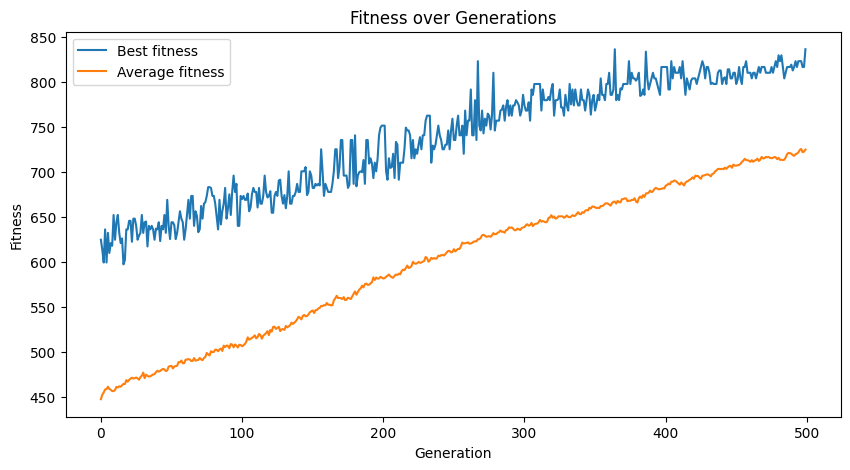

In [13]:
fitnesses_history = [h['fitnesses'] for h in history]
# plot 2 line: best fitness and average fitness
plt.figure(figsize=(10, 5))
plt.plot([max(fitness) for fitness in fitnesses_history], label='Best fitness')
plt.plot([np.mean(fitness) for fitness in fitnesses_history], label='Average fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations')
plt.legend()
plt.show()

In [14]:
from PIL import Image
shutil.rmtree('ga', ignore_errors=True)
os.makedirs('ga', exist_ok=True)
images = []

best_fitness = 0
for i in tqdm(range(len(history))):
    if history[i]['best_fitness'] > best_fitness:
        fig = plot_chromosome(history[i]['best_chromosome'])
        fig.savefig(f'ga/{i}.png')
        plt.close(fig)
        images.append(Image.open(f'ga/{i}.png'))
        best_fitness = history[i]['best_fitness']
images[0].save('ga.gif', save_all=True, append_images=images[1:], optimize=False, duration=600, loop=0)

100%|██████████| 500/500 [00:09<00:00, 52.26it/s]


Best fitness: 836.1290322580645, makespan: 37200


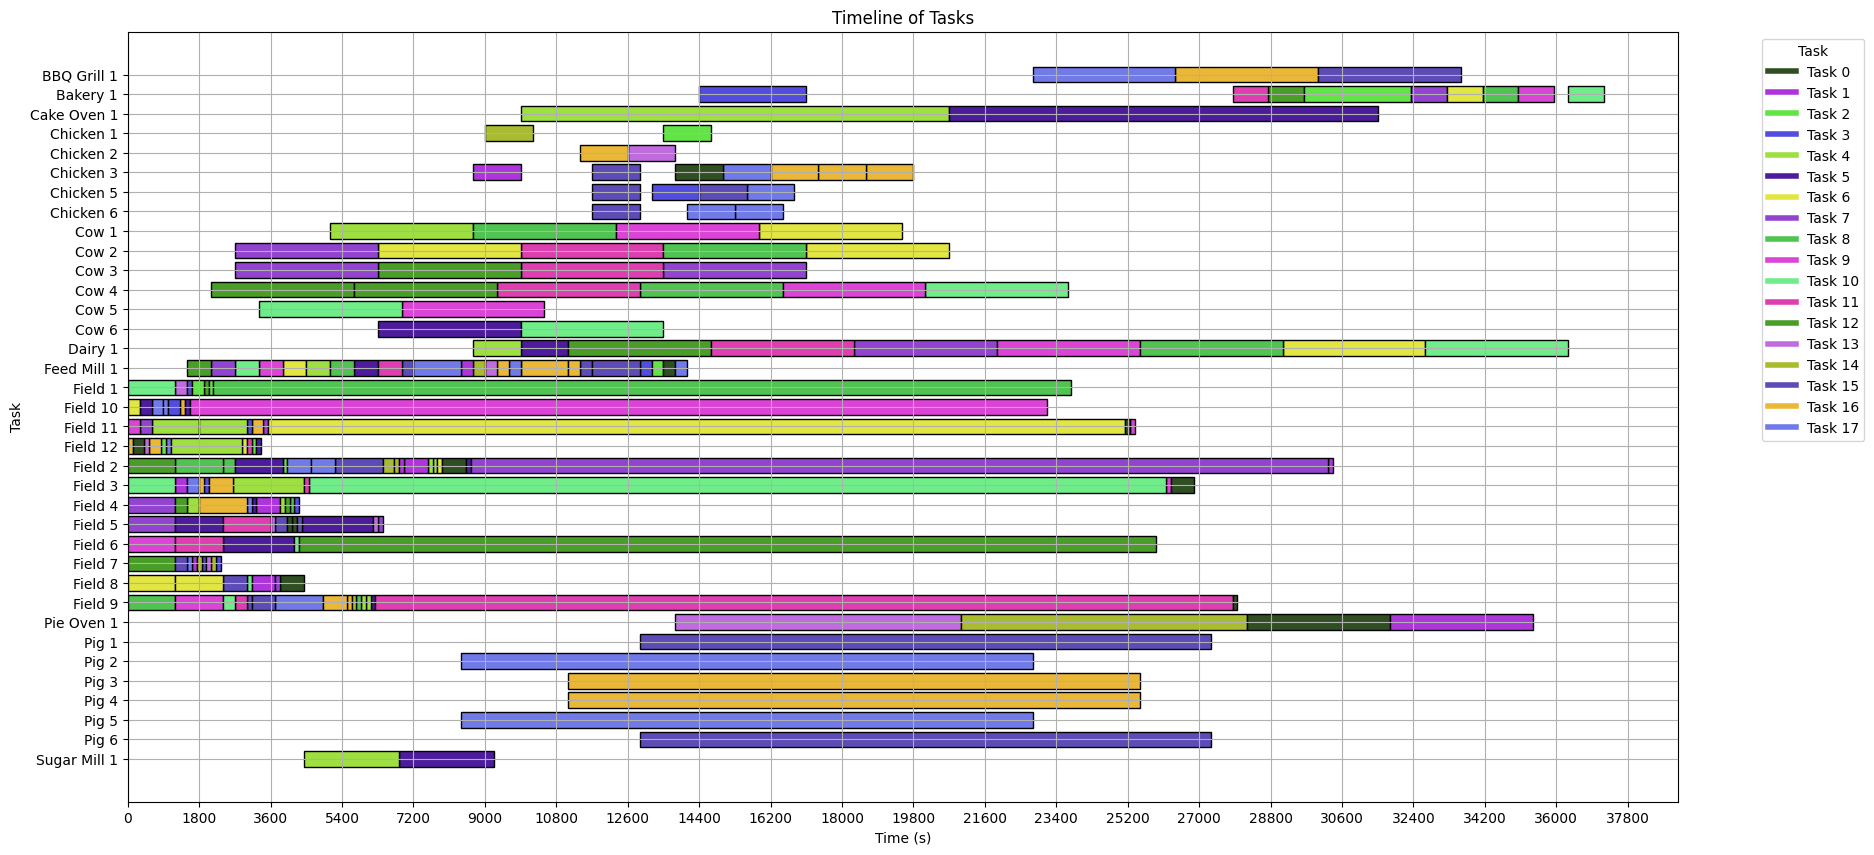

In [15]:
# 37200 
temp = calc_start_end_time(best_chromosome)
print(f"Best fitness: {fitness(best_chromosome)}, makespan: {max(task['end_time'] for task in temp.values())}")
plot_chromosome(best_chromosome,show_text=False)                
plt.show()